In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from util.pca import perform_pca
from util.k_folds_cross_val import k_folds_x_val, get_cmat, get_metrics
from util.hpo import gridSearchHPO
from util.forward_select import forward_select, forward_select_and_fit

from sklearn import tree   # Decision Trees
from sklearn import metrics
import sklearn as skl

# Data Loading

In [2]:
NUM_CLASSES = 6
CLASSES = ["sadnesss", "joy", "love", "anger", "fear"]

# Load all data
train_data = pd.read_csv("../data/training_bert_reduced.csv")
test_data = pd.read_csv("../data/validation_bert_reduced.csv")
validation_data = pd.read_csv("../data/test_bert_reduced.csv")

# Separate X's and y's from each other
FEATURE_COLUMNS = [x for x in train_data if x.startswith("e_")]
LABEL_COLUMN = "label"

In [3]:
X_train = train_data[FEATURE_COLUMNS]
Y_train = train_data[LABEL_COLUMN]

X_test = test_data[FEATURE_COLUMNS]
Y_test = test_data[LABEL_COLUMN]

X_val = validation_data[FEATURE_COLUMNS]
Y_val = validation_data[LABEL_COLUMN]

# These are used to run cross validation
X_train_val = pd.concat([X_train, X_val]) 
Y_train_val = pd.concat([Y_train, Y_test])

# These are used to run val and test for Neural Nets
X_val_test = pd.concat([X_val, X_test])
Y_val_test = pd.concat([Y_val, Y_test])

In [4]:
X_train_unreduced = X_train.to_numpy()
X_val_unreduced = X_val.to_numpy()
X_test_unreduced = X_test.to_numpy()
X_train_val_unreduced = X_train_val.to_numpy()
X_val_test_unreduced = X_val_test.to_numpy()

In [5]:
X_train_used = X_train_unreduced
X_val_used = X_val_unreduced
X_test_used = X_test_unreduced
X_train_val_used = X_train_val_unreduced 
X_val_test_used = X_val_test_unreduced

# Decision Tree Classifier

In [6]:
decision_tree_model = tree.DecisionTreeClassifier(
    criterion ='entropy', 
    splitter = 'best',
    max_depth = 256, 
    max_features = 'sqrt',
    max_leaf_nodes = 80,
)

# Grid Search Hyperparameter Optimization

In [7]:
dt_search_space = {
    'ccp_alpha':[0.1],
    'min_impurity_decrease':[1.0], # float
    'min_weight_fraction_leaf':[0.1],
    'min_samples_leaf':[0.1], 
    'min_samples_split':[0.1],
    }

model_dt = decision_tree_model.fit(X_train_used, Y_train)

gridsearch_dt = gridSearchHPO(model=model_dt, search_space=dt_search_space)

In [8]:
gridsearch_dt.fit(X_train_used, Y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5, error_score='raise',
             estimator=DecisionTreeClassifier(criterion='entropy',
                                              max_depth=256,
                                              max_features='sqrt',
                                              max_leaf_nodes=80),
             n_jobs=-1,
             param_grid={'ccp_alpha': [0.1], 'min_impurity_decrease': [1.0],
                         'min_samples_leaf': [0.1], 'min_samples_split': [0.1],
                         'min_weight_fraction_leaf': [0.1]},
             scoring='accuracy', verbose=3)

In [9]:
print("Best Score: {}".format(gridsearch_dt.best_score_))
print("Best params: {}".format(gridsearch_dt.best_params_))

Best Score: 0.335125
Best params: {'ccp_alpha': 0.1, 'min_impurity_decrease': 1.0, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1, 'min_weight_fraction_leaf': 0.1}


(0.352, 0.18328994082840236)


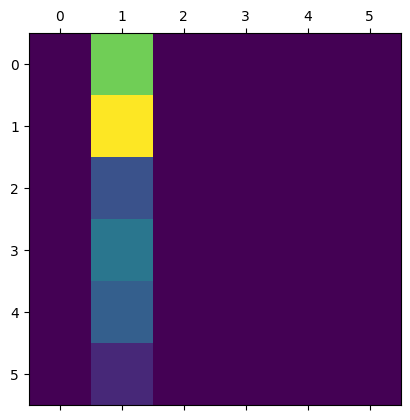

In [11]:
print(get_metrics(gridsearch_dt, X_test_used, Y_test))
c = get_cmat(gridsearch_dt, X_test_used, Y_test)
plt.matshow(c)
plt.show()